# Predicting Car Prices

In this project we will develop, and test, a model that predicts car prices based on set of car features, making use of the k-nearest-neighbor (KNN) algorithm.

**Data source**

We will make use of a (small) set of data that was published in the UCI Machine Learning Repository. It contains data of 200+ cars from the 1985 edition of Ward's Automotive Yearbook. Visit the UCI site to find [a description of the data](https://archive.ics.uci.edu/ml/datasets/automobile), and to [download the data](https://archive.ics.uci.edu/ml/machine-learning-databases/autos/). 

**About KNN**

Let me explain in layman's term about KNN and how we will apply it to the problem at hand.

Suppose we have a collection of cars, including their prices. Now we have a new car for which we don't know the price, but want to predict it. What makes sense then, is that you look for some similar cars (e.g. "other cars that are large and have a strong engine" - if that's what characterizes the new car), and use the known prices of those similar cars to do the prediction.

So that is KNN. NN stands for "nearest neighbors", that is: the "most similar" cars from our set. K represents the *number* of most similar cars that is used. E.g. K=3 means that you take the 3 most similar cars. Then, to make a prediction of the price, we will take the mean price of the selected set. 

For "most similar" we look at one or more features, such as the examples of "size" and "engine power". Suppose we only take one feauture, e.g. size. Which we (happen to) have as "length in mm". Then a distance between a car in our known set and the new car can be calculated: the difference in this length. E.g. 22mm (similar) or 136mm (not so similar). Those cars for which that distance is the lowest are the "most similar" once. This is called a univariate model.

In a multivariate model you would look for similarity for more than one feature at the same time. E.g. both for "length in mm" and for "engine power in kW" you know the difference between the new car and any other car. E.g. 22 (mm) and 12 (kW) And you need to consider both of those to define the distance. It goes a bit a far to explain the math, however the "Eucledian distance" is a good measure. For a model with two features, this can be imagined as the straight-line distance between two points (x1,y1) and (x2,y2) in a plain. For a model with three features, as the straight-line distance in a three-dimensional space. Then, also here, most similar are those with the lowest difference in distance.

Many sources on the web explain this with more detail (and possibly better...). Refer e.g. [here](https://towardsdatascience.com/k-nearest-neighbors-knn-explained-cbc31849a7e3).
 
**Notebook structure**

This notebook has the following structure:
1. Data preparation  
1.1 Initial data exploration  
1.2 Data cleaning  
1.3 Data normalization  
2. Predicting prices (KNN)  
2.1 Preparations  
2.2 Univariate model: one feature column    
2.3 Univariate model: vary k   
2.4 A side-step: correlation table   
2.5 Multivariate model: more than one feature column  
2.6 Univariate model: vary k  
2.7 Sensitivity to the split train / test  
3. Conclusions and possible next steps


# 1. Data preparation

In this section we will make the data suitable for our goal: importing, cleaning and normalizing.


## 1.1 Initial data exploration

Let's start with importing the data and do some initial exploration.

In [1]:
# Import relevant libraries and enable plotting inline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

As the data does not contains any headers, they will be added during the import of the data. Column names were taken from "import-85.names" file in the [data folder](https://archive.ics.uci.edu/ml/machine-learning-databases/autos/).

In [2]:
# Specify the column names (taken from "import-85.names")
colnames = ["symboling", "normalized-losses", "make", "fuel-type", "aspiration", "num-of-doors", "body-style", "drive-wheels", "engine-location", "wheel-base", "length", "width", "height", "curb-weight", "engine-type", "num-of-cylinders", "engine-size", "fuel-system", "bore", "stroke", "compression-ratio", "horsepower", "peak-rpm", "city-mpg", "highway-mpg", "price"]

# Import the data (saved in the same folder as this notebook) into a dataframe
cars = pd.read_csv('imports-85.data', names = colnames, header = None)

In [3]:
# Show a sample (ensure that all columns are visible)
pd.set_option('display.max_columns', None)
cars.head(5)

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


In [4]:
# Show info about dataframe and columns
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
symboling            205 non-null int64
normalized-losses    205 non-null object
make                 205 non-null object
fuel-type            205 non-null object
aspiration           205 non-null object
num-of-doors         205 non-null object
body-style           205 non-null object
drive-wheels         205 non-null object
engine-location      205 non-null object
wheel-base           205 non-null float64
length               205 non-null float64
width                205 non-null float64
height               205 non-null float64
curb-weight          205 non-null int64
engine-type          205 non-null object
num-of-cylinders     205 non-null object
engine-size          205 non-null int64
fuel-system          205 non-null object
bore                 205 non-null object
stroke               205 non-null object
compression-ratio    205 non-null float64
horsepower           205 non-nul

What we can observe is that there are 205 rows, and that *technically* there are no missing values (205 non-null for all columns). However, in the sample, we see that column 'normalized-losses' contains "?" values. So there are missing values - at least in this column. And possibly in more, which needs to be analyzed and then cleaned.

The target column, the one that we will want to predict, is column 'price'.

There appear to be quite some columns with numerical values that could act as feature columns. Not only those columns being float64 or int64, but also some of the columns of type 'object'. Some will be more interesting than others probably, e.g. one would expect that 'horsepower' is more relevant than 'height' for a price.

## 1.2 Data cleaning


In this section we'll proceed with cleaning the data.

Above we already noticed that at least one column contains "?". Let's replace "?" with "NaN", and then check for NaN values.

In [5]:
# Replace all "?" values with NaN
cars.replace("?", np.nan, inplace = True)

In [6]:
# Count NaN values for all columns
cars.isnull().sum()

symboling             0
normalized-losses    41
make                  0
fuel-type             0
aspiration            0
num-of-doors          2
body-style            0
drive-wheels          0
engine-location       0
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
engine-type           0
num-of-cylinders      0
engine-size           0
fuel-system           0
bore                  4
stroke                4
compression-ratio     0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 4
dtype: int64

Looking at what we know by now, it looks sensible to do the following:
* throw away the rows that do not contain a price; data without target value we cannot use
* ignore columns that do not contain numeric values; they are not usable for KNN
* columns that seem to contain numeric values but are currently "object": convert to a numerical format
* columns with NaN values: replace the NaN value with the column mean 

For some of these steps we need to do some more checks on the data first.

A question mark are the columns 'num-of-doors' and 'num-of-cilinders'. It may be possible to convert them from text to numbers, but even then they are not continuous. They *are* ordinal though, and more doors and more cilinders could well correlate with a higher price, so possibly we can use them. For those two we will do a bit more analysis first.

Let's proceed with all of the above.

In [7]:
# Drop rows for which there is no price
cars = cars[cars['price'].notna()]

# Check how many rows are left (should be 201 as we had 205 before and observed 4 NaN values)
print (len(cars))

201


In [8]:
# Explore what values we have for num-of-doors
cars['num-of-doors'].value_counts()

four    113
two      86
Name: num-of-doors, dtype: int64

In [9]:
# Explore what values we have for num-of-cilinders
cars['num-of-cylinders'].value_counts()

four      157
six        24
five       10
eight       4
two         4
three       1
twelve      1
Name: num-of-cylinders, dtype: int64

Given this data for 'num-of-doors' and 'num-of-cilinders', they may be of use. Let's keep them. And convert to numeric values.

In [10]:
# Create dictionary to replace words with numeric values
replace_dict = {"two": 2, "three": 3, "four": 4, "five": 5, "six": 6, "eight": 8, "twelve": 12}

# Replace num-of-doors, num-of-cylinders with numeric values
cars = cars.replace({"num-of-doors": replace_dict, "num-of-cylinders": replace_dict})

In [11]:
# Check result (num-of-doors)
cars['num-of-doors'].value_counts()

4    113
2     86
Name: num-of-doors, dtype: int64

In [12]:
# Check result (num-of-cylinders)
cars['num-of-cylinders'].value_counts()

4     157
6      24
5      10
8       4
2       4
12      1
3       1
Name: num-of-cylinders, dtype: int64

That looks good.

Let's now get rid of the columns that we will not use. That is, everything that is non-numeric. And then transform object columns to float columns.

In [13]:
# Specify the relevant columns and keep those
relevant_columns = ["symboling", "normalized-losses", "num-of-doors", "wheel-base", "length", "width", "height", "curb-weight", "num-of-cylinders", "engine-size", "bore", "stroke", "compression-ratio", "horsepower", "peak-rpm", "city-mpg", "highway-mpg", "price"]
cars = cars[relevant_columns]

# Check the result
cars.head(3)

,symboling,normalized-losses,num-of-doors,wheel-base,length,width,height,curb-weight,num-of-cylinders,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,NaN,2,88.6,168.8,64.1,48.8,2548,4,130,3.47,2.68,9.0,111,5000,21,27,13495
1,3,NaN,2,88.6,168.8,64.1,48.8,2548,4,130,3.47,2.68,9.0,111,5000,21,27,16500
2,1,NaN,2,94.5,171.2,65.5,52.4,2823,6,152,2.68,3.47,9.0,154,5000,19,26,16500


In [14]:
# Convert columns from objects to float
cars = cars.astype({'normalized-losses': float, 'bore': float, 'stroke': float, 'horsepower': float, 'peak-rpm': float, 'price': float})

In [15]:
# Confirm that all relevant columns now have a numeric type (int or float)
cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201 entries, 0 to 204
Data columns (total 18 columns):
symboling            201 non-null int64
normalized-losses    164 non-null float64
num-of-doors         199 non-null object
wheel-base           201 non-null float64
length               201 non-null float64
width                201 non-null float64
height               201 non-null float64
curb-weight          201 non-null int64
num-of-cylinders     201 non-null int64
engine-size          201 non-null int64
bore                 197 non-null float64
stroke               197 non-null float64
compression-ratio    201 non-null float64
horsepower           199 non-null float64
peak-rpm             199 non-null float64
city-mpg             201 non-null int64
highway-mpg          201 non-null int64
price                201 non-null float64
dtypes: float64(11), int64(6), object(1)
memory usage: 29.8+ KB


Before replacing the remaining NaN values with column means, let's eye-ball a sample of the values of those columns to see whether that seems to be sensible.

In [16]:
# Show a (sizeable, reproducable random) sample of the columns that contain NaN values
cars[['normalized-losses', 'bore', 'stroke', 'horsepower', 'peak-rpm']].sample(20, random_state = 1)

,normalized-losses,bore,stroke,horsepower,peak-rpm
100,106.0,3.33,3.47,97.0,5200.0
120,154.0,2.97,3.23,68.0,5500.0
62,115.0,3.39,3.39,84.0,4800.0
36,78.0,2.92,3.41,76.0,6000.0
169,134.0,3.62,3.50,116.0,4800.0
151,87.0,3.05,3.03,62.0,4800.0
29,145.0,3.60,3.90,145.0,5000.0
81,153.0,3.35,3.46,88.0,5000.0
4,164.0,3.19,3.40,115.0,5500.0
19,98.0,3.03,3.11,70.0,5400.0


For all of them, that looks okay indeed to replace NaN with column mean.

In [17]:
# Replace NaN values with columns' mean. (Will be applied to multiple columns.)
cars.fillna(cars.mean(), inplace = True)

In [18]:
# Confirm that there are no NaN values anymore
cars.isnull().sum()

symboling            0
normalized-losses    0
num-of-doors         0
wheel-base           0
length               0
width                0
height               0
curb-weight          0
num-of-cylinders     0
engine-size          0
bore                 0
stroke               0
compression-ratio    0
horsepower           0
peak-rpm             0
city-mpg             0
highway-mpg          0
price                0
dtype: int64

## 1.3 Data normalization

As a final preparation step we will apply min-max normalization, so we get values in the interval [0,1] for each column. This is important to avoid that during k-nearest neighbor some columns weigh in more than others.

The target column (price) remains unchanged.

In [19]:
# Create a new dataframe, with normalized columns (min-max normalization)
cars_norm = (cars - cars.min()) / (cars.max() - cars.min())

# Put the original price column back in place.
cars_norm['price'] = cars['price']

# Show a couple of rows to check the result
cars_norm.head(5)

,symboling,normalized-losses,num-of-doors,wheel-base,length,width,height,curb-weight,num-of-cylinders,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,1.0,0.298429,0.0,0.058309,0.413433,0.324786,0.083333,0.411171,0.2,0.260377,0.664286,0.290476,0.1250,0.294393,0.346939,0.222222,0.289474,13495.0
1,1.0,0.298429,0.0,0.058309,0.413433,0.324786,0.083333,0.411171,0.2,0.260377,0.664286,0.290476,0.1250,0.294393,0.346939,0.222222,0.289474,16500.0
2,0.6,0.298429,0.0,0.230321,0.449254,0.444444,0.383333,0.517843,0.4,0.343396,0.100000,0.666667,0.1250,0.495327,0.346939,0.166667,0.263158,16500.0
3,0.8,0.518325,1.0,0.384840,0.529851,0.504274,0.541667,0.329325,0.2,0.181132,0.464286,0.633333,0.1875,0.252336,0.551020,0.305556,0.368421,13950.0
4,0.8,0.518325,1.0,0.373178,0.529851,0.521368,0.541667,0.518231,0.3,0.283019,0.464286,0.633333,0.0625,0.313084,0.551020,0.138889,0.157895,17450.0


That looks okay.

E.g. for 'num-of-cylinders', for which we know that the original values varied from 2 to 12, it can easily be confirmed (with some arithmetic) that the values of the first couple of rows are correct.

Our data is now ready to apply k-nearest neighbor.

# 2. Predicting prices (KNN)

Now we have suitable data, we can proceed with the actual machine learning part: predicting the target column (price) based on feature columns. And validating the result.

What will do consecutively:
* univariate model: using one feature column at a time
* univariate model: tune the value of k
* multivariate model: using more than one feature column at a time
* multivariate model: tune the value of k

During those steps we will use 75% of our data for training and 25% for testing (validation). We will, at the end, do a check though till what extent that choice (75/25) has impact on the results.

## 2.1 Preparations

For all of this, let's import the relevant parts of skikit-learn, and define a function to be able to do what will follow efficiently.

In [20]:
# Import from skikit-learn that we will use
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

The function that we will define will takes as inputs:
* the feauture columns to use (which can be one or more)
* the target column (which will be 'price')
* the dataframe to use (which will be 'cars-norm')
* the value of k (with a default of 5)
* the fraction of the data to use for testing (with a default of 0.25)

And will return the RMSE (root-mean-square-error) of a comparison between the actual values and the predicted values in the test set. This indicates the quality of the predictions for the provided inputs.

In [21]:
# Create a function that takes all relevant inputs,trains a train set, predicts on the test set, and returns an RMSE
def knn_train_test(train_col, target_col, df, k = 5, test_fraction = 0.25):

    # Split dataframe in (reproducable random) train and test sets
    train_df, test_df = train_test_split(df, test_size=test_fraction, random_state = 1)
    
    # Instantiate KNN object
    knn = KNeighborsRegressor(k)
    
    # Train model for feature column on train set
    knn.fit(train_df[train_col],train_df[target_col])
    
    # Create predictions for target column for test set
    predictions = knn.predict(test_df[train_col])
    
    # Get actual values for target column for test set
    actuals = test_df[target_col]
    
    # Get and return RMSE for predictions
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    return rmse

In [22]:
# Test function with one column (using default values for k and test_fraction)
print (knn_train_test(["wheel-base"], "price", cars_norm)   )

# Test function with two columns (while using different values for k and test_frac)
print (knn_train_test(["wheel-base", "horsepower"], "price", cars_norm, 3, 0.4)  ) 

4942.417612750214
3794.081404283778


These initial values indicate errors in the price in the order of magnitude of 4000. To get some sense how that relates to the price value itself, let's get descriptive statistics for price.

In [23]:
# Get descriptive statistics for price
cars['price'].describe()

count      201.000000
mean     13207.129353
std       7947.066342
min       5118.000000
25%       7775.000000
50%      10295.000000
75%      16500.000000
max      45400.000000
Name: price, dtype: float64

Okay, so those are errors in the order of magnitude of half a standard deviation of the price variation.

## 2.2 Univariate model: one feature column

We'll start with getting the results for all univariate models, using one feauture column at a time. That will give us an indication which car features appear to have the best predictive value for the price.

At this point, we will use the typical values of k = 5 (number of nearest neighbors) and a split our dataset in 75% for training and 25% for testing.

In [24]:
# Get all columns (except price)
all_feature_columns = cars_norm.columns.to_list()
all_feature_columns.remove('price')

# Instanstiate dictionary to collect the results
knn_one_feature_results = {}

# For each of the columns get the knn-result (using k = 5)
for column in all_feature_columns:
    rmse = knn_train_test([column], 'price', cars_norm, 5)
    knn_one_feature_results[column] = rmse
    
# Print the results (in sequence) 
for k in sorted(knn_one_feature_results, key=knn_one_feature_results.get, reverse=False):
    print (k, knn_one_feature_results[k])


horsepower 3309.547325126942
city-mpg 3498.2814474381844
engine-size 3568.017767475326
curb-weight 3846.1211499889287
length 3929.2878126334554
width 3937.650346161712
highway-mpg 4003.437151777869
wheel-base 4942.417612750214
num-of-cylinders 5485.080977971243
normalized-losses 6287.165337883389
stroke 6483.215850359523
compression-ratio 6567.353117400301
bore 6642.258305431853
symboling 7067.5068527540525
peak-rpm 7253.6975779902195
num-of-doors 7337.342547784547
height 7724.860453184671


What we can see is that the RMSE is lowest for horse power, followed by city-mpg and engine-size. Based on this, those appear to be the best predictors for the price.

## 2.3 Univariate model: vary k

Above, we used a (default) value of k = 5. Let's now get results for different values of k as well (1, 3, 5, 7, 9), and assess till what extent such hyperparameter tuning can improve the predictions. That is: vary with the number of nearest neighbors to use for prediction, and see what that means for error indicator RMSE.

In [25]:
# Instanstiate a list-of-lists to collect the results
knn_one_f_many_k = []

# Iterate over all feauture columns and k-values, get the RMSE, and add it into list of list
for column in all_feature_columns:
    for k in [1,3,5,7,9]:
        rmse = knn_train_test([column], 'price', cars_norm, k)
        knn_one_f_many_k.append([column, k, rmse])
        
# Convert the list of lists to a dataframe
knn_one_f_many_k_df = pd.DataFrame(knn_one_f_many_k, columns = ['feature', 'k', 'RMSE'])

# Show a sample of the results
knn_one_f_many_k_df.head(8)

,feature,k,RMSE
0,symboling,1,8302.931621
1,symboling,3,7008.004334
2,symboling,5,7067.506853
3,symboling,7,6899.059290
4,symboling,9,6736.482833
5,normalized-losses,1,9767.500143
6,normalized-losses,3,6025.784830
7,normalized-losses,5,6287.165338


Let's create a line plot of these results.

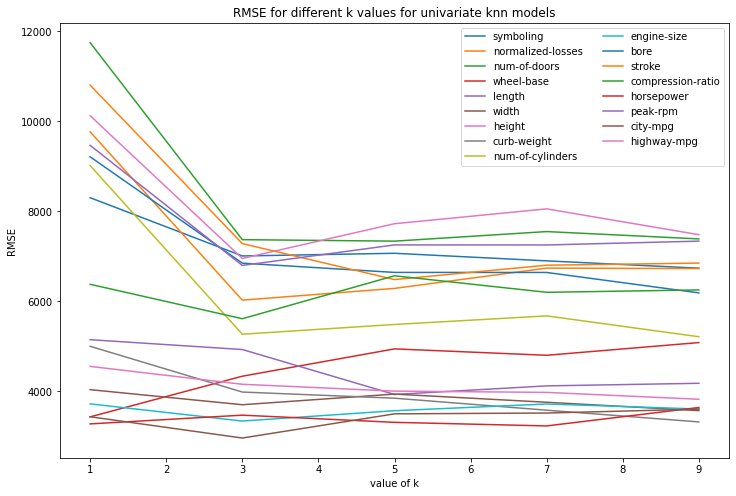

In [26]:
# Instantiate plot
fig, ax = plt.subplots(figsize = (12,8))

# Simplify dataframe name for convenience
kom = knn_one_f_many_k_df.copy()

# Plot a line for every feature
for feature in all_feature_columns:
    plt.plot(kom[kom['feature']==feature]['k'], kom[kom['feature']==feature]['RMSE'])
    
# Set various drawing attributes
ax.set_xlabel('value of k')
ax.set_ylabel('RMSE')
plt.title('RMSE for different k values for univariate knn models')
plt.legend(all_feature_columns, ncol = 2)

# Show
plt.show()

Let's show the 10 best values also in table format.

In [27]:
# Show top 10 results with the lowest RMSE
kom.sort_values('RMSE').head(10)

,feature,k,RMSE
76,city-mpg,3,2960.584969
68,horsepower,7,3229.901320
65,horsepower,1,3274.848061
67,horsepower,5,3309.547325
39,curb-weight,9,3318.738145
46,engine-size,3,3338.422037
15,wheel-base,1,3431.347083
75,city-mpg,1,3433.937884
66,horsepower,3,3469.091557
77,city-mpg,5,3498.281447


So the best result is for city-mpg with a k-value of 3, followed by horsepower for different k-values.

When we looking at the graph, the best result for k hovers between 3 and 6 for most (but not all) 
feautures, and seems to be 3 if you had to pick one number.

## 2.4 A side-step: correlation table

If our only goal had been to "identify the features that correlate most to price", but without wanting to actually create and validate a KNN model, we could just directly have created a correlation table between 'price' and all features.

Let us still create such table anyway (using a piece of [code found here](https://www.datasnips.com/48/sorted-absolute-correlation-table/)), and see till what exent the features that surface are similar.

In [28]:
# Create correlation table with one column, display sorted on absolute correlation
def correlation_table(data,target_column):
    data_num = data.select_dtypes(include=['int','float'])
    corr_df = pd.DataFrame(data_num.corrwith(data_num[target_column]),columns=['Correlation']).dropna()
    corr_df['ABS Correlation'] = abs(corr_df['Correlation'])
    corr_df.sort_values(by=['ABS Correlation'], ascending=False, inplace=True)
    print(corr_df)

correlation_table(cars_norm, 'price')

                   Correlation  ABS Correlation
price                 1.000000         1.000000
engine-size           0.872335         0.872335
curb-weight           0.834415         0.834415
horsepower            0.809681         0.809681
width                 0.751265         0.751265
num-of-cylinders      0.708645         0.708645
highway-mpg          -0.704692         0.704692
length                0.690628         0.690628
city-mpg             -0.686571         0.686571
wheel-base            0.584642         0.584642
bore                  0.543154         0.543154
height                0.135486         0.135486
normalized-losses     0.133999         0.133999
peak-rpm             -0.101542         0.101542
symboling            -0.082391         0.082391
stroke                0.082267         0.082267
compression-ratio     0.071107         0.071107
num-of-doors          0.046481         0.046481


Interesting. Not exactly the same. What we observe here is that engine-size, curb-weight and horsepower form the top-3 in terms of correlation with price. They also rank high above (univariate models, comparison of RMSE) although not necessarily in that sequence. Our best univariate model used city-mpg though, and that only ranks as the 6th-most feature for correlation with price, which is surprising.

Not easy to say what to conclude from this, in particular for selection of features for a multi-variate model. Let's consider the earlier list, that is 'features that give the best results in a univariate model' leading.

## 2.5 Multivariate model: more than one feature column

It is likely that we will get better predictions in case we use more than one feature column at a time. In this section we will do that. We can use the same function that we created before, but then provide multiple columns as training columns.

As for which feauture columns to use, we will use combinations of feature columns that came out best in the previous step (univariate models). You may argue what is "best", as for different values of k that differs. What we'll do is rank the features by 'lowest RMSE observed' - regardless of the k value that that was for.

Refering to a table we printed before the top five features (from best to worst) are:
1. city-mpg
2. horsepower
3. curb-weight
4. engine-size
5. wheel-base

From that list let's train/validate with the the top 1 (that is: univariate still), top 2, top 3, top 4 and top 5 (that is: all 5 of them). We will use k = 5 again (use 5 nearest neighbors).

In [29]:
# List with the top-5 feautures
top_5_features = ['city-mpg', 'horsepower', 'curb-weight', 'engine-size', 'wheel-base']

# Iterate through top 1 - top 5, for each get (and print) them RMSE for train/test
for i in range(1,6):
    selected_features = top_5_features[0:i]
    rmse = knn_train_test(selected_features,"price", cars_norm,5)
    print (selected_features)
    print (rmse)


['city-mpg']
3498.2814474381844
['city-mpg', 'horsepower']
3790.514570376335
['city-mpg', 'horsepower', 'curb-weight']
2901.5647794615516
['city-mpg', 'horsepower', 'curb-weight', 'engine-size']
3177.0166670549743
['city-mpg', 'horsepower', 'curb-weight', 'engine-size', 'wheel-base']
3272.241707837275


We do not see a very clear pattern. Adding the 2nd feature makes things... worse! But than adding the 3rd feature gives the best result found so far. So it not obvious that one of these five patters will perform best. Let's try out some more combinations from the top-5 feautures. 

In [30]:
# 1, 3
selected_features = ['city-mpg', 'curb-weight']
rmse = knn_train_test(selected_features,"price", cars_norm, 5)
print (selected_features)
print (rmse)

# 2, 3
selected_features = ['horsepower', 'curb-weight']
rmse = knn_train_test(selected_features,"price", cars_norm, 5)
print (selected_features)
print (rmse)

# 1, 2, 4
selected_features = ['city-mpg', 'horsepower', 'engine-size']
rmse = knn_train_test(selected_features,"price", cars_norm, 5)
print (selected_features)
print (rmse)

# 2, 3, 4
selected_features = ['horsepower', 'curb-weight', 'engine-size']
rmse = knn_train_test(selected_features,"price", cars_norm,5)
print (selected_features)
print (rmse)


['city-mpg', 'curb-weight']
2961.9839372801944
['horsepower', 'curb-weight']
2646.5734490424543
['city-mpg', 'horsepower', 'engine-size']
2932.103291522463
['horsepower', 'curb-weight', 'engine-size']
3291.183136329965


Indeed, these are not necessarily worse. The combination of feature 2 and 3 ('horsepower' and 'curb-weight') even gives the best result so far. One might want to continue with even more different permuations of these top 5 features (or even include different feautures again). 

Rather, let us take the best feature combinations we found so far, and start varying with the k value to see what effect that has.

## 2.6 Univariate model: vary k

The best feauture combinations we found (with k = 5) are:
* set 1: 'horsepower', 'curb-weight': 2646.5734490424543
* set 2: 'city-mpg', 'horsepower', 'curb-weight': 2901.5647794615516
* set 3: 'city-mpg', 'horsepower', 'engine-size': 2932.103291522463

For these three combinations, let us try out a range of different k-values (1-25).

In [31]:
# Instanstiate a list-of-lists to collect the results
knn_multi_f_many_k = []

# Instantiate the sets
set1 = ['horsepower', 'curb-weight']
set2 = ['city-mpg', 'horsepower', 'curb-weight']
set3 = ['city-mpg', 'horsepower', 'engine-size']

all_sets = [set1, set2, set3]

# Iterate through all sets and a range of k-values and get RMSE, and add it into list of list
for set in all_sets:
    for k in range(1,25):
        rmse = knn_train_test(set, 'price', cars_norm, k)
        # Create a set-identifier; keeping the entire set itself as identifier gives errors later on when trying to filter the result-dataframe for plotting
        setname = ', '.join(set)  
        knn_multi_f_many_k.append([setname, k, rmse])
        
# Convert the list of lists to a dataframe
knn_multi_f_many_k_df = pd.DataFrame(knn_multi_f_many_k, columns = ['feature-set', 'k', 'RMSE'])

# Show a (reproducable) sample of the results
knn_multi_f_many_k_df.sample(5, random_state = 1)

,feature-set,k,RMSE
19,"horsepower, curb-weight",20,3479.461168
55,"city-mpg, horsepower, engine-size",8,2999.898323
10,"horsepower, curb-weight",11,3355.498960
68,"city-mpg, horsepower, engine-size",21,4162.309674
53,"city-mpg, horsepower, engine-size",6,2954.003198


Let's plot the results.

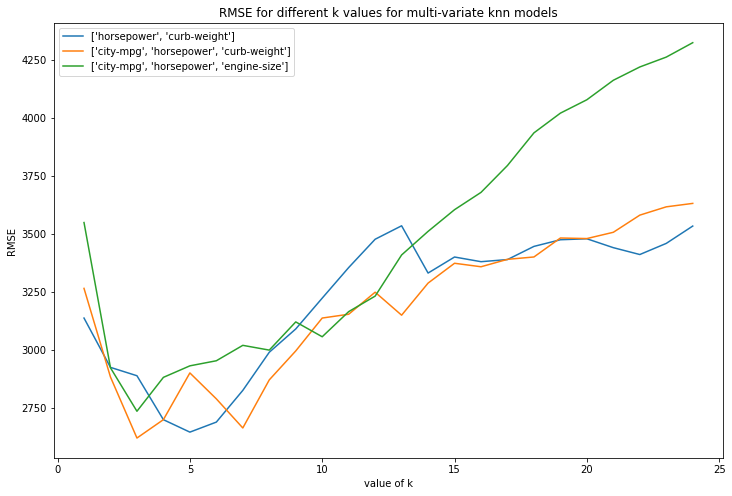

In [32]:
# Instantiate plot
fig, ax = plt.subplots(figsize = (12,8))

# Simplify df name for convenience
kmm = knn_multi_f_many_k_df.copy()

# Get set-names
set_names = kmm['feature-set'].unique()

# Plot a line for every set
for set in set_names:
    plt.plot(kmm[kmm['feature-set']==set]['k'], kmm[kmm['feature-set']==set]['RMSE'])
    
# Set various drawing attributes
ax.set_xlabel('value of k')
ax.set_ylabel('RMSE')
plt.title('RMSE for different k values for multi-variate knn models')
plt.legend(all_sets)

# Show
plt.show()

Let's also list the ten best results.

In [33]:
# List the 10 best results (lowest RMSE)
kmm.sort_values('RMSE').head(10)

,feature-set,k,RMSE
26,"city-mpg, horsepower, curb-weight",3,2621.125230
4,"horsepower, curb-weight",5,2646.573449
30,"city-mpg, horsepower, curb-weight",7,2664.520537
5,"horsepower, curb-weight",6,2689.808407
3,"horsepower, curb-weight",4,2700.128805
27,"city-mpg, horsepower, curb-weight",4,2700.386380
50,"city-mpg, horsepower, engine-size",3,2736.485256
29,"city-mpg, horsepower, curb-weight",6,2789.845446
6,"horsepower, curb-weight",7,2826.372538
31,"city-mpg, horsepower, curb-weight",8,2871.616589


The thing that stands out is that lower k-values are better. This is not entirely unexpected. The data set is very small (only 201 records after cleaning) and still covers a wide variety of cars. Therefore one can expect that adding too many neighbors means including neighbors that are really not so near, making the model worse.

As for the best feauture set, that seems to include horse-power and curb-weight in any case, either or not with city-mpg added to it.

## 2.7 Sensitivity to the split train / test

So far, for all experiments we used a value of 0.25 for input parameter test_fraction, meaning that we used 75% for training and 25% for testing.

That is a common way to split. However, given the very small amount of data that we have, we may wonder whether it has significant impact which records end up and in training and test set. 

One could vary with different random seeds. Let's try something else though: vary with this fraction. What we will do is take our best univariate result, and our best multivariate result, and for both of them try out different fractions for train/test.

In [34]:
# Best univariate result found: city-mpg, k = 3
selected_features = ['city-mpg']
k = 3

# Try out different fractions for train/test
for test_fraction in (0.05, 0.1, 0.25, 0.5):
    rmse = knn_train_test(selected_features,"price", cars_norm, k, test_fraction)
    print ("For test_fraction", test_fraction, "the RMSE is", rmse)

For test_fraction 0.05 the RMSE is 1751.4815546741097
For test_fraction 0.1 the RMSE is 3731.1404316421704
For test_fraction 0.25 the RMSE is 2960.5849687685836
For test_fraction 0.5 the RMSE is 4162.384902025191


In [35]:
# Best multivariate result found: city-mpg + horsepower + curb-weight, k = 3
selected_features = ['city-mpg','horsepower', 'curb-weight']
k = 3

for test_fraction in (0.05, 0.1, 0.25, 0.5):
    rmse = knn_train_test(selected_features,"price", cars_norm, 3, test_fraction)
    print ("For test_fraction", test_fraction, "the RMSE is", rmse)

For test_fraction 0.05 the RMSE is 980.2870121870562
For test_fraction 0.1 the RMSE is 2128.8577581645404
For test_fraction 0.25 the RMSE is 2621.1252302717025
For test_fraction 0.5 the RMSE is 3312.9853096967136


So. That has **a lot** of influence indeed. The outcomes vary wildly with the fractions train / test. This really means that we should be very careful to draw any conclusion from what we have seen so far.

One might consider:
* Analyzing better which value for test-fraction appears to give the best results
* Redoing the univariate tests again with that test-fraction, as this may then also impact which features are best
* Also vary with different random-seeds for creation of the train/test datasets, as it may then have impact as well which orders happen to be selected for both sets
* Or, as an alternative to test/train, apply K-fold validation instead to get more consistent results

However, given the very small size of the dataset, we may wonder whether we can get to a good model altogether.

# 3. Conclusions and possible next steps

What we have seen is that when applying k-nearest neighbor on our small set of data, the following features appear to be the best predictors for the price:
* city-mpg
* horsepower
* curb-weight
* engine-size

Using a multivariate model, using several of these features at the same time, gives slightly better results: the RMSE (root-mean-square-error) decreases with approximately 10 percent points.

The optimal number for k (that is: the number of nearest neighbors to use for prediction) seems to be around 3.

However, the very small size of the data makes it heard to build a robust, reliable model: slight variations in which data is in the training set and which in the test set, give significant differences in the outcome.

Therefore, rather than trying to improve the prediction model further, let's leave it to this, consider this a great excercise, and do a next project with a larger dataset!